<a href="https://colab.research.google.com/github/csataridominik/colab_links/blob/main/RMT_in_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tensorflow.keras.datasets import mnist

import torch.nn.functional as F

In [ ]:
W = net.out1.weight.detach().cpu().numpy()

sigma2 = np.var(W)
sigma2

np.float32(0.0008332902)

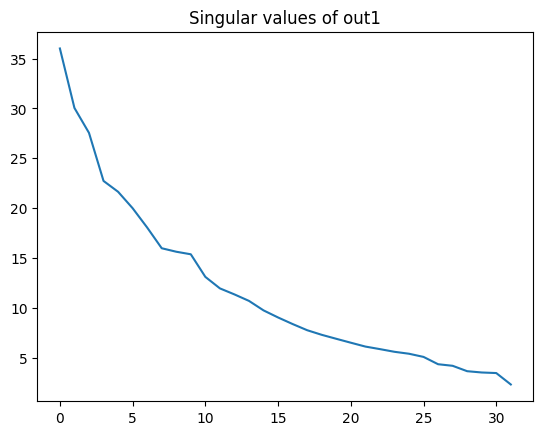

In [ ]:
W = model.l2.weight.data
W =  W.view(W.size(0), -1)


U, S, V = torch.svd(W)
import matplotlib.pyplot as plt
plt.plot(S.detach().cpu().numpy())
plt.title("Singular values of out1")
plt.show()

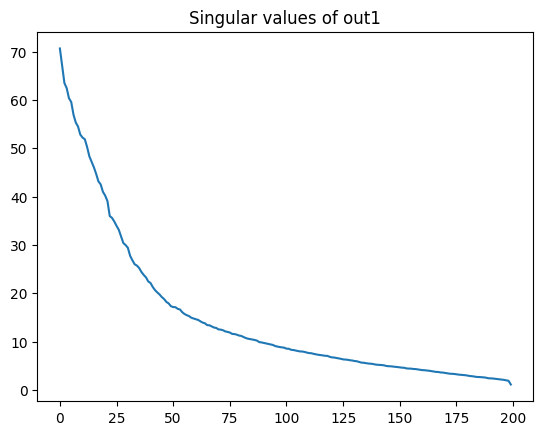

In [ ]:
W = model.out1.weight.data
U, S, V = torch.svd(W)
import matplotlib.pyplot as plt
plt.plot(S.detach().cpu().numpy())
plt.title("Singular values of out1")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mp_weights_separate(w_init, w_trained, bins=50):
    """
    Plot eigenvalue spectrum + MP law for
    (1) initial weights
    (2) trained weights
    on two separate figures.
    """

    def mp_pdf(x, sigma2, q, lam_minus, lam_plus):
        return np.sqrt((lam_plus - x) * (x - lam_minus)) / (2 * np.pi * sigma2 * q * x)

    def plot_single(W, title):
        p, n = W.shape
        q = p / n

        # covariance matrix
        C = (1 / n) * (W @ W.T)

        # eigenvalues
        eigvals = np.linalg.eigh(C)[0]

        # MP parameters
        sigma2 = np.var(W)
        lam_minus = sigma2 * (1 - np.sqrt(q))**2
        lam_plus  = sigma2 * (1 + np.sqrt(q))**2

        # MP curve
        x = np.linspace(lam_minus, lam_plus, 1000)
        mp = mp_pdf(x, sigma2, q, lam_minus, lam_plus)

        # plot
        plt.figure(figsize=(8, 5))
        plt.hist(eigvals, bins=bins, density=True, alpha=0.7, label="Eigenvalues")
        plt.plot(x, mp, 'r', lw=2, label="Marchenko–Pastur")

        plt.xlabel("Eigenvalue")
        plt.ylabel("Density")
        plt.title(title)
        plt.legend()
        plt.show()

    # plots
    plot_single(w_init, "Initial Weights: Spectrum vs MP")
    plot_single(w_trained, "Trained Weights: Spectrum vs MP")


Network:



In [ ]:
class SimpleNN(nn.Module):
  def __init__(self,h=28,w=28):
    super().__init__()
    self.l1 = nn.Conv2d(1,16,3) # 28 x 28 x 1--> 26 x 26 x 16
    self.l2 = nn.Conv2d(16,32,3) # 26 x 26 x 16--> 24 x 24 x 32
    self.l3 = nn.Conv2d(32,64,5) # 24 x 24 x 32--> 20 x 20 x 64
    self.activation = nn.ReLU()
    #self.l4 = nn.Conv2d(64,1,1)

    self.encode = nn.Sequential(
        self.l1,
        self.activation,
        self.l2,
        self.activation,
        self.l3,
        self.activation,
        #self.l4
    )

    self.out1 = nn.Linear(20*20,20*20//2)
    self.b1 = nn.BatchNorm1d(20*20//2)

    self.out2 = nn.Linear(20*20//2,20*20//4)
    self.b2 = nn.BatchNorm1d(20*20//4)

    self.out3 = nn.Linear(20*20//4,10)



  def forward(self,x):
    encoded_x = self.encode(x)
    # encoded_x: [N, 64, 20, 20]
    encoded_x = torch.max(encoded_x, dim=1, keepdim=True)[0]  # [N, 1, 20, 20]

    encoded_x = encoded_x.view(encoded_x.size(0), -1)

    out1 = self.activation(self.b1(self.out1(encoded_x)))
    out2 = self.activation(self.b2(self.out2(out1)))
    return self.out3(out2)



inp = torch.rand([8,1,28,28])
net = SimpleNN()

out = net(inp)

out.shape


torch.Size([8, 10])

In [ ]:
net.out1.weight


Parameter containing:
tensor([[ 0.0389, -0.0410, -0.0115,  ..., -0.0114,  0.0237,  0.0042],
        [-0.0351, -0.0462, -0.0407,  ...,  0.0266,  0.0191,  0.0072],
        [-0.0403, -0.0306, -0.0402,  ...,  0.0314,  0.0281,  0.0369],
        ...,
        [ 0.0322,  0.0491, -0.0336,  ...,  0.0057,  0.0350, -0.0485],
        [ 0.0340,  0.0459,  0.0375,  ..., -0.0256, -0.0461,  0.0350],
        [ 0.0047,  0.0317,  0.0200,  ...,  0.0090,  0.0250, -0.0385]],
       requires_grad=True)

Data:

In [ ]:
(X, y), (_, _) = mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
X = torch.Tensor(X)
'''
labels = []
for i in range(len(X)):
    zero_y = np.zeros(10)
    zero_y[y[i]] = 1
    labels.append(zero_y)


print(labels)'''
y = torch.Tensor(y)




Dataloaders


In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device = 'cpu'

In [ ]:
from torch.utils.data import dataset, DataLoader

class Dataset(torch.utils.data.Dataset):
  def __init__(self,x,y):
    super().__init__()
    self.x = x
    self.y = y
  def __len__(self):
      return len(self.y)

  def __getitem__(self, idx):
      x = self.x[idx]
      y = self.y[idx]

      return x,y

batch = 32

train_dataset = Dataset(X[:int(len(X)*0.8)],y[:int(len(X)*0.8)])
validation_dataset = Dataset(X[int(len(X)*0.8):],y[int(len(X)*0.8):])
print(validation_dataset.x.shape,train_dataset.x.shape)

train_dataloader = DataLoader(train_dataset,batch,shuffle=True)

validation_dataloader = DataLoader(validation_dataset,batch,shuffle=True)

torch.Size([12000, 28, 28]) torch.Size([48000, 28, 28])


Training loop

In [ ]:
epochs = 10
model = SimpleNN().to(device)
lr = 0.01
opt = torch.optim.Adam(model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

# schedule later...

for epoch in range(epochs):
  training_loss = 0
  validation_loss = 0
  correct = 0
  validation_correct = 0

  # training:
  model.train()
  for (x,y) in train_dataloader:
    x = x[:,None,:,:].to(device)
    y = y.long().to(device)
    y_pred = model(x)
    loss = criterion(y_pred,y)

    loss.backward()
    opt.step()
    opt.zero_grad()

    training_loss += loss.item()
    correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()


  # valdiaiton:
  model.eval()
  with torch.no_grad():
    for (x,y) in validation_dataloader:
      x = x[:,None,:,:].to(device)
      y = y.long().to(device)

      y_pred = model(x)
      loss = criterion(y_pred,y)

      validation_loss += loss.item()
      validation_correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()




  print(f'Epoch {epoch} | Training Loss: {(training_loss/ len(train_dataloader)):.4f} | Train accuracy: {(correct / len(train_dataloader.dataset)):.4f} | Val Loss: {(validation_loss/ len(validation_dataloader)):.4f} | Val accuracy: {(validation_correct / len(validation_dataloader .dataset)):.4f}')






Epoch 0 | Training Loss: 0.2293 | Train accuracy: 0.9293 | Val Loss: 0.1025 | Val accuracy: 0.9704
Epoch 1 | Training Loss: 0.1082 | Train accuracy: 0.9676 | Val Loss: 0.0804 | Val accuracy: 0.9751
Epoch 2 | Training Loss: 0.0878 | Train accuracy: 0.9732 | Val Loss: 0.0703 | Val accuracy: 0.9788
Epoch 3 | Training Loss: 0.0729 | Train accuracy: 0.9774 | Val Loss: 0.0725 | Val accuracy: 0.9788
Epoch 4 | Training Loss: 0.0651 | Train accuracy: 0.9802 | Val Loss: 0.0686 | Val accuracy: 0.9818
Epoch 5 | Training Loss: 0.0557 | Train accuracy: 0.9820 | Val Loss: 0.0606 | Val accuracy: 0.9831


KeyboardInterrupt: 

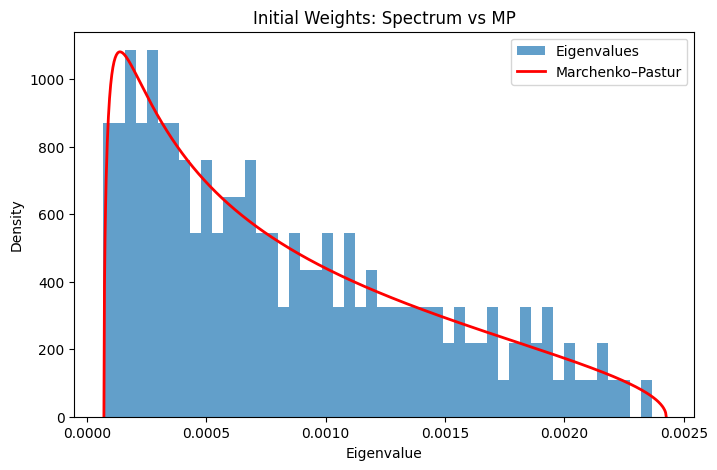

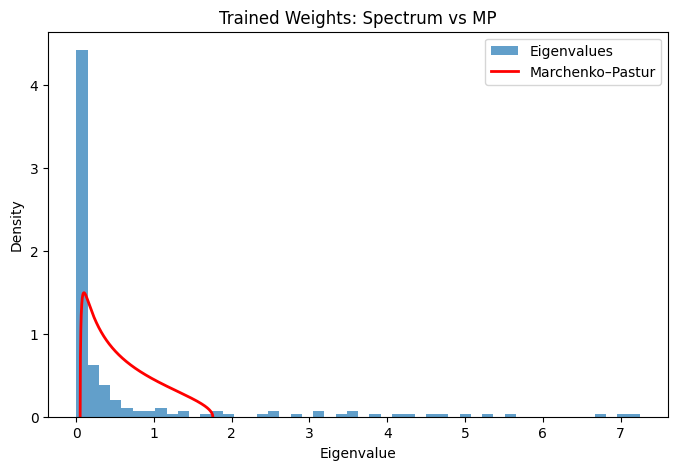

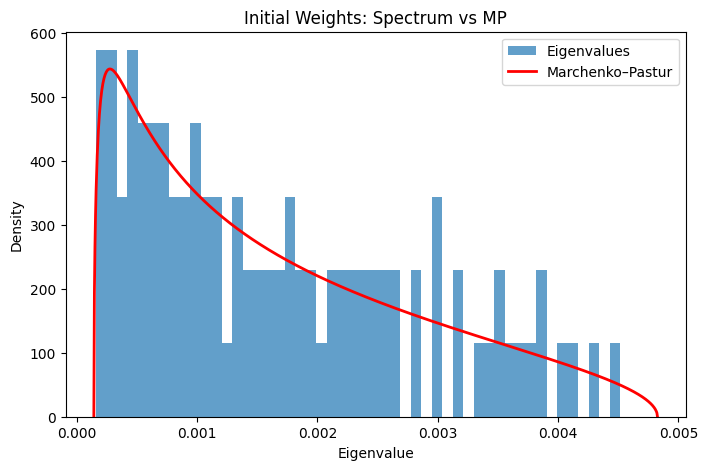

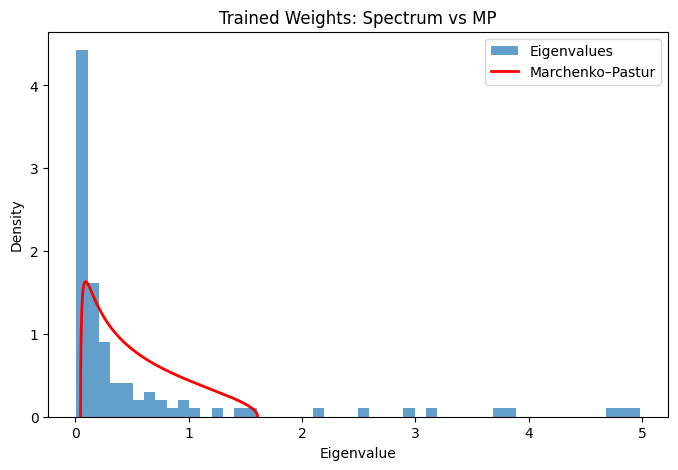

In [ ]:
w_init = net.out1.weight.detach().cpu().numpy()
w_trained = model.out1.weight.detach().cpu().numpy()

plot_mp_weights_separate(w_init, w_trained)


w_init = net.out2.weight.detach().cpu().numpy()
w_trained = model.out2.weight.detach().cpu().numpy()

plot_mp_weights_separate(w_init, w_trained)

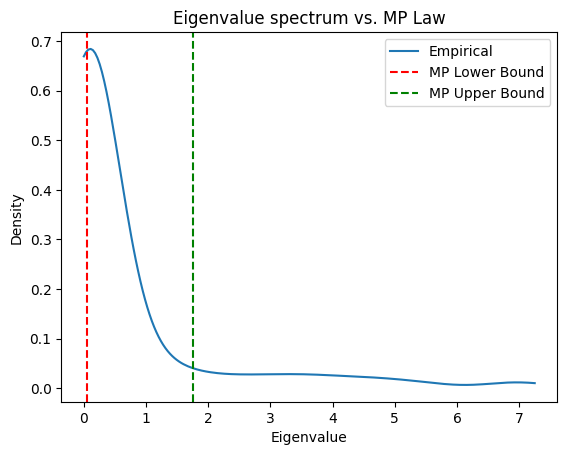

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

W = model.out1.weight.detach().cpu().numpy()

N, M = W.shape
Q = N / M

# 1. Compute covariance
C = np.dot(W, W.T) / M

# 2. Compute eigenvalues
eigvals = np.linalg.eigvalsh(C)

# 3. Theoretical MP edges
sigma2 = np.var(W)
lambda_minus = sigma2 * (1 - np.sqrt(Q))**2
lambda_plus  = sigma2 * (1 + np.sqrt(Q))**2

# 4. Plot
density = gaussian_kde(eigvals)
xs = np.linspace(min(eigvals), max(eigvals), 200)
plt.plot(xs, density(xs), label='Empirical')
plt.axvline(lambda_minus, color='r', linestyle='--', label='MP Lower Bound')
plt.axvline(lambda_plus, color='g', linestyle='--', label='MP Upper Bound')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.title('Eigenvalue spectrum vs. MP Law')
plt.legend()
plt.show()
